In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/checkpoints/checkpoint-3.pkl
/kaggle/input/checkpoints/checkpoint-5.pkl
/kaggle/input/checkpoints/checkpoint-1.pkl
/kaggle/input/checkpoints/checkpoint-2.pkl
/kaggle/input/checkpoints/checkpoint-4.pkl
/kaggle/input/birds23sp/birds/sample.csv
/kaggle/input/birds23sp/birds/names.txt
/kaggle/input/birds23sp/birds/labels.csv
/kaggle/input/birds23sp/birds/test/0/6378ee1e3d2b48d287bebebda32c8268.jpg
/kaggle/input/birds23sp/birds/test/0/a14a6bbd400d4506875967db56005090.jpg
/kaggle/input/birds23sp/birds/test/0/a6a2cc77b4d54f93b2e92aa7a1a5e7d8.jpg
/kaggle/input/birds23sp/birds/test/0/b002317a54ee4ac89fe1d36a886f099c.jpg
/kaggle/input/birds23sp/birds/test/0/1978addc377e422a85a8618cdac93839.jpg
/kaggle/input/birds23sp/birds/test/0/000ef8cc723046a08415e13eb13bbc28.jpg
/kaggle/input/birds23sp/birds/test/0/d4af23cacede4e74a269e7d669d8e4d0.jpg
/kaggle/input/birds23sp/birds/test/0/9d3ce71cfbcb42309f47450ee9502511.jpg
/kaggle/input/birds23sp/birds/test/0/857a768df3394750bb645d980beb7eb8.j

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ColorJitter(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds23sp/birds/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds23sp/birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("/kaggle/input/birds23sp/birds/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

torch.Size([8, 3, 128, 128])


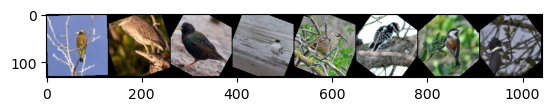

Labels:Evening Grosbeak (Adult Male), Yellow-crowned Night-Heron (Immature), European Starling (Breeding Adult), Common Tern, California Thrasher, Hairy Woodpecker, Chestnut-backed Chickadee, Belted Kingfisher


In [4]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [5]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [6]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [7]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

In [8]:
!pip install timm

In [9]:
class Darknet64(nn.Module):
    def __init__(self):
        super(Darknet64, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 555)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        return x

In [10]:
# Train the darknet64 model
checkpoints = '/kaggle/working/'
net = Darknet64()
state = torch.load('/kaggle/input/checkpoints/checkpoint-5.pkl')
losses = train(net, data['train'], epochs=5, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints, state=None)

Learning rate: 0.100000
[0,    10] loss: 6.542
[0,    20] loss: 6.510
[0,    30] loss: 6.525
[0,    40] loss: 6.385
[0,    50] loss: 6.331
[0,    60] loss: 6.287
[0,    70] loss: 6.282
[0,    80] loss: 6.265
[0,    90] loss: 6.259
[0,   100] loss: 6.211
[0,   110] loss: 6.220
[0,   120] loss: 6.179
[0,   130] loss: 6.212
[0,   140] loss: 6.170
[0,   150] loss: 6.142
[0,   160] loss: 6.094
[0,   170] loss: 6.129
[0,   180] loss: 6.126
[0,   190] loss: 6.041
[0,   200] loss: 6.097
[0,   210] loss: 6.061
[0,   220] loss: 6.072
[0,   230] loss: 6.041
[0,   240] loss: 6.059
[0,   250] loss: 6.100
[0,   260] loss: 6.028
[0,   270] loss: 6.037
[0,   280] loss: 6.085
[0,   290] loss: 6.020
[0,   300] loss: 6.026
[0,   310] loss: 5.980
[0,   320] loss: 5.937
[0,   330] loss: 5.987
[0,   340] loss: 5.967
[0,   350] loss: 5.925
[0,   360] loss: 5.943
[0,   370] loss: 5.888
[0,   380] loss: 5.902
[0,   390] loss: 5.920
[0,   400] loss: 5.933
[0,   410] loss: 5.920
[0,   420] loss: 5.918
[0,   430]

In [15]:
pretrain_net = Darknet64()

# Load weights from pretrained ImageNet model
state = torch.load('/kaggle/working/checkpoint-5.pkl')
pretrain_net.load_state_dict(state['net'], strict=False)

<All keys matched successfully>

In [12]:
# Get the accuracy of the darknet64 model
print("Training accuracy: %f" % accuracy(net, data['train']))

Training accuracy: 0.094264


In [13]:
# Train the resnet18 model and store intermediate results in checkpoints
checkpoints = '/kaggle/working/'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
losses = train(model, data['train'], epochs=3, lr=.01, print_every=10, checkpoint_path=checkpoints)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


[0,    10] loss: 9.902
[0,    20] loss: 7.502
[0,    30] loss: 6.982
[0,    40] loss: 6.804
[0,    50] loss: 6.694
[0,    60] loss: 6.600
[0,    70] loss: 6.511
[0,    80] loss: 6.567
[0,    90] loss: 6.484
[0,   100] loss: 6.514
[0,   110] loss: 6.477
[0,   120] loss: 6.443
[0,   130] loss: 6.400
[0,   140] loss: 6.419
[0,   150] loss: 6.416
[0,   160] loss: 6.382
[0,   170] loss: 6.398
[0,   180] loss: 6.345
[0,   190] loss: 6.337
[0,   200] loss: 6.354
[0,   210] loss: 6.238
[0,   220] loss: 6.294
[0,   230] loss: 6.219
[0,   240] loss: 6.250
[0,   250] loss: 6.196
[0,   260] loss: 6.231
[0,   270] loss: 6.157
[0,   280] loss: 6.141
[0,   290] loss: 6.170
[0,   300] loss: 6.239
[0,   310] loss: 6.084
[0,   320] loss: 6.099
[0,   330] loss: 6.100
[0,   340] loss: 6.056
[0,   350] loss: 6.111
[0,   360] loss: 6.095
[0,   370] loss: 6.065
[0,   380] loss: 5.936
[0,   390] loss: 6.026
[0,   400] loss: 5.996
[0,   410] loss: 5.931
[0,   420] loss: 6.011
[0,   430] loss: 5.952
[0,   440] 

In [29]:
# Train the efficientnet_v2_l model and store intermediate results in checkpoints
checkpoints = '/kaggle/working/'
model = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT').to(device)
losses = train(model, data['train'], epochs=20, lr=.007, print_every=10, checkpoint_path=checkpoints)

[0,    10] loss: 7.858
[0,    20] loss: 7.158
[0,    30] loss: 6.921
[0,    40] loss: 6.797
[0,    50] loss: 6.718
[0,    60] loss: 6.719
[0,    70] loss: 6.699
[0,    80] loss: 6.628
[0,    90] loss: 6.611
[0,   100] loss: 6.525
[0,   110] loss: 6.508
[0,   120] loss: 6.503
[0,   130] loss: 6.439
[0,   140] loss: 6.446
[0,   150] loss: 6.325
[0,   160] loss: 6.380
[0,   170] loss: 6.372
[0,   180] loss: 6.255
[0,   190] loss: 6.275
[0,   200] loss: 6.239
[0,   210] loss: 6.161
[0,   220] loss: 6.065
[0,   230] loss: 6.090
[0,   240] loss: 5.961
[0,   250] loss: 5.910
[0,   260] loss: 5.864
[0,   270] loss: 5.884
[0,   280] loss: 5.812
[0,   290] loss: 5.700
[0,   300] loss: 5.547
[0,   310] loss: 5.442
[0,   320] loss: 5.521
[0,   330] loss: 5.301
[0,   340] loss: 5.262
[0,   350] loss: 5.274
[0,   360] loss: 5.227
[0,   370] loss: 5.125
[0,   380] loss: 4.953
[0,   390] loss: 4.912
[0,   400] loss: 4.833
[0,   410] loss: 4.852
[0,   420] loss: 4.687
[0,   430] loss: 4.640
[0,   440] 

KeyboardInterrupt: 

We ran this and it cleared the output, but the saved results from the earlier checkpoints are used below!

In [26]:
# Evaluate the training accuracy using the last set of checkpoints
model = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT').to(device)
state = torch.load(checkpoints + 'checkpoint-11.pkl')
model.load_state_dict(state['net'])
print("Training accuracy: %f" % accuracy(model, data['train']))

Training accuracy: 0.913801


Note that this is the training accuracy from running 11 epochs instead of 20. The first output with 20 epochs accidentally cleared. We tried rerunning and the output cleared again after 11 epochs.

In [27]:
# Generate the csv file with our predictions
predict(model, data['test'], "/kaggle/working/" + "submissions.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


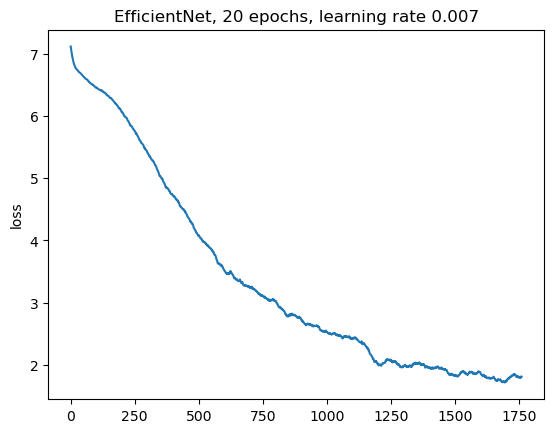

In [28]:
# Plot the losses
plt.title("EfficientNet, 20 epochs, learning rate 0.007")
plt.ylabel("loss")
plt.plot(smooth(losses, 50))

In [20]:
# Hyperparameter tuning: tested different decay values
checkpoints = '/kaggle/working/'
# state = torch.load(checkpoints + 'checkpoint-12.pkl')
model = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT').to(device)
losses = train(model, data['train'], epochs=3, lr=.007, momentum=0.9, decay=0.0005, print_every=10, checkpoint_path=checkpoints, state=None)
# losses = train(model, data['train'], epochs=3, lr=.007, momentum=0.9, decay=0.00001, print_every=10, checkpoint_path=checkpoints, state=state)
# losses = train(model, data['train'], epochs=3, lr=.007, momentum=0.9, decay=0.009, print_every=10, checkpoint_path=checkpoints, state=state)
# losses = train(model, data['train'], epochs=3, lr=.007, momentum=0.9, decay=0.005, print_every=10, checkpoint_path=checkpoints, state=state)
print("Training accuracy: %f" % accuracy(model, data['train']))

[0,    10] loss: 7.904
[0,    20] loss: 7.253
[0,    30] loss: 6.882
[0,    40] loss: 6.801
[0,    50] loss: 6.768
[0,    60] loss: 6.721
[0,    70] loss: 6.680
[0,    80] loss: 6.641
[0,    90] loss: 6.603
[0,   100] loss: 6.547
[0,   110] loss: 6.521
[0,   120] loss: 6.470
[0,   130] loss: 6.459
[0,   140] loss: 6.459
[0,   150] loss: 6.381
[0,   160] loss: 6.374
[0,   170] loss: 6.397
[0,   180] loss: 6.313
[0,   190] loss: 6.293
[0,   200] loss: 6.184
[0,   210] loss: 6.199
[0,   220] loss: 6.133
[0,   230] loss: 6.114
[0,   240] loss: 5.959
[0,   250] loss: 5.921
[0,   260] loss: 5.882
[0,   270] loss: 5.914
[0,   280] loss: 5.679
[0,   290] loss: 5.720
[0,   300] loss: 5.590
[0,   310] loss: 5.547
[0,   320] loss: 5.511
[0,   330] loss: 5.392
[0,   340] loss: 5.365
[0,   350] loss: 5.254
[0,   360] loss: 5.210
[0,   370] loss: 5.201
[0,   380] loss: 5.016
[0,   390] loss: 4.920
[0,   400] loss: 4.794
[0,   410] loss: 4.859
[0,   420] loss: 4.742
[0,   430] loss: 4.853
[0,   440] 

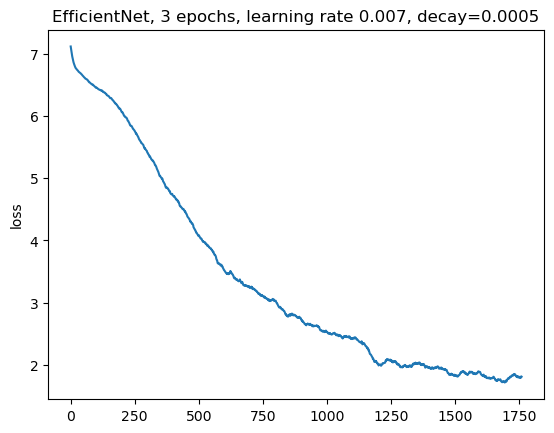

In [22]:
# Plot the different decay models
plt.title("EfficientNet, 3 epochs, learning rate 0.007, decay=0.0005")
plt.ylabel("loss")
plt.plot(smooth(losses, 50))